## Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [135]:
import numpy as np
import shutil
import re
import json
from pathlib import Path
import os
from collections import namedtuple
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
plt.style.use('ggplot')
%matplotlib inline

In [150]:
input('are you sure?')
machines = """
ec2-3-233-221-255.compute-1.amazonaws.com
ec2-3-230-154-171.compute-1.amazonaws.com
ec2-3-235-41-184.compute-1.amazonaws.com
ec2-3-223-3-236.compute-1.amazonaws.com
""".split('\n')[1:-1]


model_path = Path('nas_results_base/')
model_path.mkdir(exist_ok=True)
for i in range(len(machines)):
    (model_path/str(i)).mkdir(exist_ok=True)

location = '~/fairness/deco/src/deco/post_hoc/results'

for i, machine in enumerate(machines):
    os.system(f"scp  -i ~/.ssh/ec2-key \"ubuntu@{machine}:{location}/*\" {str(model_path)}/{i}/")

are you sure d


In [179]:
model_path = Path('nas_results_bm/')

In [180]:
len(list(model_path.glob('**/*test_output.json')))

40

In [181]:
import json, re

data = {}
for file_results in model_path.glob('**/*test_output.json'):
    keys = re.match(fr'{model_path}/(\d)/(\w+_\w+_\d)_(\d)_baselines_test_output.json', str(file_results))
    with open(file_results) as fh:
        datum = json.load(fh)
    data.update({keys.groups() : {(k,kk): vv for k,v in datum.items() for kk,vv in v.items()}})
    
plotdf = pd.DataFrame(data).T.unstack(0).unstack(0).describe().loc[['count', 'mean', 'std']].T.unstack(1).reorder_levels([2,1,0]).sort_index().swaplevel(0,1,1).sort_index(1)
plotdf = plotdf['objective'].droplevel(0).unstack(1)

In [182]:
plotdf

count                                                mean           \
  CalibEqOdds EqOdds   ROC Random adversarial default CalibEqOdds   EqOdds   
0        10.0   10.0  10.0   10.0        10.0    10.0    0.083926  0.09339   
1        10.0   10.0  10.0   10.0        10.0    10.0    0.042286  0.09339   
2        10.0   10.0  10.0   10.0        10.0    10.0    0.108744  0.09339   
4        10.0   10.0  10.0   10.0        10.0    10.0    0.084200  0.09339   

                                                    std                \
        ROC    Random adversarial   default CalibEqOdds        EqOdds   
0  0.062682  0.044575    0.032909  0.068397    0.014867  1.462847e-17   
1  0.098475  0.054761    0.034945  0.054667    0.010756  1.462847e-17   
2  0.068692  0.042014    0.037210  0.078463    0.017693  1.462847e-17   
4  0.062406  0.041256    0.036037  0.057130    0.023692  1.462847e-17   

                                             
        ROC    Random adversarial   default  
0  0.007684  0.008512    0.001256  0.010663  
1  0.064142  0.057453    0.004748  0.015785  
2  0.014549  0.008940    0.011745  0.014007  
4  0.018128  0.008959    0.007760  0.011115

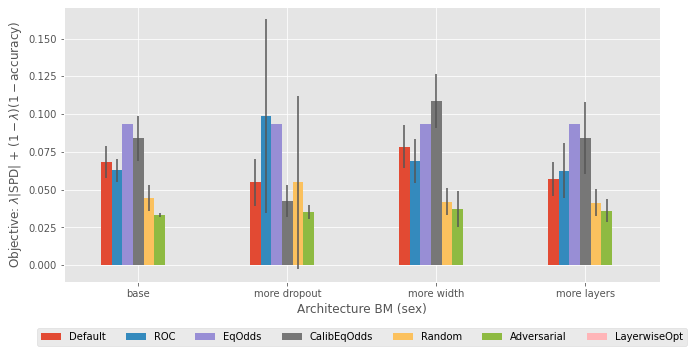

In [183]:
plotdf.index = ['base', 'more dropout', 'more width', 'more layers']

# titlename = {'spd': 'Statistical Parity Difference', 'eod': 'Equal Opportunity Difference', 'aod': 'Average Odds Difference'}
column_order = ['default', 'ROC', 'EqOdds', 'CalibEqOdds', 'Random', 'adversarial', 'layerwiseOpt']
col_rename = {'default': 'Default', 'adversarial': 'Adversarial', 'layerwiseOpt': 'LayerwiseOpt'}

plotmean = plotdf['mean'].reindex(columns=column_order).rename(columns=col_rename)
plotstd = plotdf['std'].reindex(columns=column_order).rename(columns=col_rename)
plotmean.plot(kind='bar', yerr=plotstd, figsize=(10,5), rot=0)
plt.ylabel('Objective: $\lambda$|SPD| + $(1-\lambda)(1-$accuracy$)$')
plt.xlabel('Architecture BM (sex)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.tight_layout()
# plt.savefig(f'images/{metric}_results.pdf')
plt.savefig(f'images/multinet_bm_results.png')
plt.savefig(f'images/multinet_bm_results.pdf')

In [103]:
from post_hoc.posthoc import *

In [104]:
datasets = ['adult', 'bank', 'compas']
results = {}

for dataset in datasets:
    train, valid, test, priv, unpriv = get_data(dataset, 1)
    priv_index = train.protected_attribute_names.index(list(priv[0].keys())[0])

    scale_orig = StandardScaler()
    X_train = torch.tensor(scale_orig.fit_transform(train.features), dtype=torch.float32)
    y_train = torch.tensor(train.labels.ravel(), dtype=torch.float32)
    # p_train = train.protected_attributes[:, priv_index]

    X_valid = torch.tensor(scale_orig.transform(valid.features), dtype=torch.float32)
    y_valid = torch.tensor(valid.labels.ravel(), dtype=torch.float32)
    p_valid = valid.protected_attributes[:, priv_index]

    X_test = torch.tensor(scale_orig.transform(test.features), dtype=torch.float32)
    y_test = torch.tensor(test.labels.ravel(), dtype=torch.float32)
    p_test = test.protected_attributes[:, priv_index]

    model = Model(X_train.size(1))

    roc_auc_scores = []
    accs = []
    for path in model_path.glob('*'):
        if dataset in str(path):
            model.load_state_dict(torch.load(path))
            model.eval()
            with torch.no_grad():
                yhat_test = model(X_test)[:, 0].reshape(-1, 1).numpy()
            roc_auc_scores.append(roc_auc_score(y_test, yhat_test))

            model.eval()
            with torch.no_grad():
                yhat_valid = model(X_valid)[:, 0].reshape(-1, 1).numpy()
                
            threshs = np.linspace(0,1,1001)
            bthresh = threshs[np.argmax([accuracy_score(y_valid, yhat_valid > thresh) for thresh in threshs])]
            accs.append(accuracy_score(y_test, yhat_test > bthresh))
    results[(dataset,  'neural network', 'roc_auc')] = roc_auc_scores
    results[(dataset, 'neural network', 'accuracy')] = accs
    
    roc_auc_scores = []
    accs = []
    for i in range(10):
        lr = LogisticRegressionCV()
        lr.fit(X_train, y_train)
        
        yhat_test = lr.predict_proba(X_test)[:,1]
        roc_auc_scores.append(roc_auc_score(y_test, yhat_test))
        
        yhat_valid = lr.predict_proba(X_valid)[:,1]
        threshs = np.linspace(0,1,1001)
        bthresh = threshs[np.argmax([accuracy_score(y_valid, yhat_valid > thresh) for thresh in threshs])]
        accs.append(accuracy_score(y_test, yhat_test > bthresh))
    results[(dataset,  'logistic regression', 'roc_auc')] = roc_auc_scores
    results[(dataset, 'logistic regression', 'accuracy')] = accs
    
    
    roc_auc_scores = []
    accs = []
    for i in range(10):
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        
        yhat_test = rf.predict_proba(X_test)[:,1]
        roc_auc_scores.append(roc_auc_score(y_test, yhat_test))
        
        yhat_valid = rf.predict_proba(X_valid)[:,1]
        threshs = np.linspace(0,1,1001)
        bthresh = threshs[np.argmax([accuracy_score(y_valid, yhat_valid > thresh) for thresh in threshs])]
        accs.append(accuracy_score(y_test, yhat_test > bthresh))
    results[(dataset,  'random forest', 'roc_auc')] = roc_auc_scores
    results[(dataset, 'random forest', 'accuracy')] = accs
    

2020-06-10 18:25:17,752 - root - WARNING - Missing Data: 3620 rows removed from AdultDataset.
2020-06-10 18:26:32,447 - root - WARNING - Missing Data: 10700 rows removed from BankDataset.
2020-06-10 18:27:14,361 - root - WARNING - Missing Data: 5 rows removed from CompasDataset.


In [105]:
tmp = pd.DataFrame(results).describe().loc[['count', 'mean', 'std']].T
df = (tmp['mean'].map('{:.3f}'.format) + ' $\pm$ ' + tmp['std'].map('{:.3f}'.format)).unstack(1)
df

logistic regression     neural network      random forest
adult  accuracy   0.852 $\pm$ 0.000  0.855 $\pm$ 0.002  0.844 $\pm$ 0.002
       roc_auc    0.904 $\pm$ 0.000  0.908 $\pm$ 0.001  0.889 $\pm$ 0.000
bank   accuracy   0.901 $\pm$ 0.000  0.901 $\pm$ 0.002  0.899 $\pm$ 0.001
       roc_auc    0.930 $\pm$ 0.000  0.934 $\pm$ 0.001  0.932 $\pm$ 0.001
compas accuracy   0.677 $\pm$ 0.000  0.641 $\pm$ 0.061  0.652 $\pm$ 0.006
       roc_auc    0.725 $\pm$ 0.000  0.679 $\pm$ 0.088  0.695 $\pm$ 0.002

In [106]:
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
       &         & logistic regression &     neural network &      random forest \\
\midrule
adult & accuracy &   0.852 \$\textbackslash pm\$ 0.000 &  0.855 \$\textbackslash pm\$ 0.002 &  0.844 \$\textbackslash pm\$ 0.002 \\
       & roc\_auc &   0.904 \$\textbackslash pm\$ 0.000 &  0.908 \$\textbackslash pm\$ 0.001 &  0.889 \$\textbackslash pm\$ 0.000 \\
bank & accuracy &   0.901 \$\textbackslash pm\$ 0.000 &  0.901 \$\textbackslash pm\$ 0.002 &  0.899 \$\textbackslash pm\$ 0.001 \\
       & roc\_auc &   0.930 \$\textbackslash pm\$ 0.000 &  0.934 \$\textbackslash pm\$ 0.001 &  0.932 \$\textbackslash pm\$ 0.001 \\
compas & accuracy &   0.677 \$\textbackslash pm\$ 0.000 &  0.641 \$\textbackslash pm\$ 0.061 &  0.652 \$\textbackslash pm\$ 0.006 \\
       & roc\_auc &   0.725 \$\textbackslash pm\$ 0.000 &  0.679 \$\textbackslash pm\$ 0.088 &  0.695 \$\textbackslash pm\$ 0.002 \\
\bottomrule
\end{tabular}



In [122]:
dataset

'compas'

In [164]:
train, valid, test, priv, unpriv = get_data('adult', 1)
priv_index = train.protected_attribute_names.index(list(priv[0].keys())[0])

scale_orig = StandardScaler()
X_train = torch.tensor(scale_orig.fit_transform(train.features), dtype=torch.float32)
y_train = torch.tensor(train.labels.ravel(), dtype=torch.float32)
# p_train = train.protected_attributes[:, priv_index]

X_valid = torch.tensor(scale_orig.transform(valid.features), dtype=torch.float32)
y_valid = torch.tensor(valid.labels.ravel(), dtype=torch.float32)
p_valid = valid.protected_attributes[:, priv_index]

X_test = torch.tensor(scale_orig.transform(test.features), dtype=torch.float32)
y_test = torch.tensor(test.labels.ravel(), dtype=torch.float32)
p_test = test.protected_attributes[:, priv_index]

model = Model(X_train.size(1))
deltas = []
biases = []
for path in model_path.glob('*'):
    if 'adult' in str(path):
        deltas.append([])
        biases.append([])
        for i in range(1000):
            model.load_state_dict(torch.load(path))
            delta = []
            for param in model.parameters():
                delta.append(torch.randn_like(param) * 0.1 + 1)
                param.data = param.data * delta[-1]
            delta = torch.cat([x.reshape(-1) for x in delta])
            deltas[-1].append(delta)

            model.eval()
            with torch.no_grad():
                yhat_test = model(X_test)[:, 0].reshape(-1, 1).numpy()
            bias = compute_bias(yhat_test, y_test.numpy(), p_test, metric='spd')
            biases[-1].append(bias)

2020-06-10 19:39:12,730 - root - WARNING - Missing Data: 3620 rows removed from AdultDataset.


In [168]:
shape = len(deltas[0])
train = torch.randperm(shape)[:int(shape*0.8)]
test = torch.randperm(shape)[int(shape*0.8):]

In [169]:
from sklearn.linear_model import LinearRegression
coefs = []
scores = []
for d, b in zip(deltas, biases):
    lr = LinearRegression()
    lr.fit(torch.stack(d).numpy()[train], np.array(b)[train])
    scores.append(lr.score(torch.stack(d).numpy()[test], np.array(b)[test]))
    coefs.append(lr.coef_)
coefs = np.array(coefs)

[0.8561326047456524, 0.7683091644536558, 0.8671310757815001, 0.8460479705287975, 0.864636679868098, 0.9003736860341522, 0.9149808181785867, 0.8928201750676319, 0.8842704640037174, 0.8195441779648978]


In [193]:
print(f'{np.array(scores).mean():.3f} $\pm$ {2.2*np.array(scores).std():.3f}')

0.861 $\pm$ 0.090


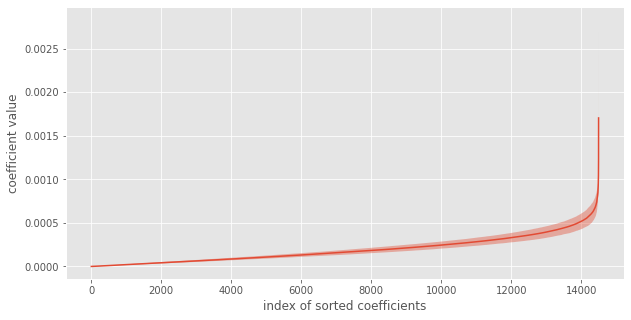

In [180]:
plt.figure(figsize=(10,5))
pdf = pd.DataFrame(np.sort(np.abs(coefs)))
pdf.mean().plot()
plt.fill_between(pdf.std().index, pdf.mean() - 2.2*pdf.std(), pdf.mean() + 2.2*pdf.std(),alpha=0.4)
plt.xlabel('index of sorted coefficients')
plt.ylabel('coefficient value')
plt.savefig('coefs_sort.pdf')

In [181]:
coefs.shape

(10, 14498)

In [182]:
from scipy.linalg import svd

In [183]:
from sklearn.preprocessing import normalize

In [184]:
U,s,Vh = svd(normalize(coefs))

In [185]:
U.shape, s.shape, Vh.shape

((10, 10), (10,), (14498, 14498))

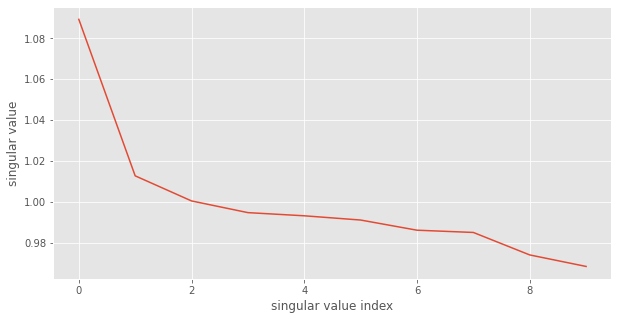

In [186]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,s.size), s)
plt.xlabel('singular value index')
plt.ylabel('singular value')
plt.savefig('coefs_svd.pdf')

In [195]:
yash1 = 'ec2-3-233-221-255.compute-1.amazonaws.com'
yash2 = 'ec2-3-230-154-171.compute-1.amazonaws.com'
yash3 = 'ec2-3-235-41-184.compute-1.amazonaws.com'
yash4 = 'ec2-3-223-3-236.compute-1.amazonaws.com'
yashs = [yash1, yash2, yash3, yash4]

results_path = Path('NAS/')
# shutil.rmtree(results_path)
results_path.mkdir(exist_ok=True)

location = '~/fairness/deco/src/deco/post_hoc/results'

for i, yash in enumerate(yashs):
    results_dirpath = Path(f'NAS/{i}')
    results_dirpath.mkdir(exist_ok=True)
    os.system(f"scp  -i ~/.ssh/ec2-key \"ubuntu@{yash}:{location}/*\" {str(results_dirpath)}/")

In [196]:
import json, re
data = {}
for result_file in results_path.glob('**/*.json'):
#     print(result_file)
    matches = re.match(r'NAS/(?P<nn_type>\d+)/(?P<dataset>\w+)_(?P<bias>\w+)_(?P<protected>\d+)_(?P<iter>\d+)_baselines_(?P<fold>\w+)_output.json', str(result_file))
    if matches.group('fold') == 'valid':
        continue
    with open(result_file, 'r') as fh:
        datum = json.load(fh)
    datum = {(matches.group('nn_type'), matches.group('iter'), k): v for k,v in datum.items()}
    data.update(datum)
#     data = dict(data, **datum)

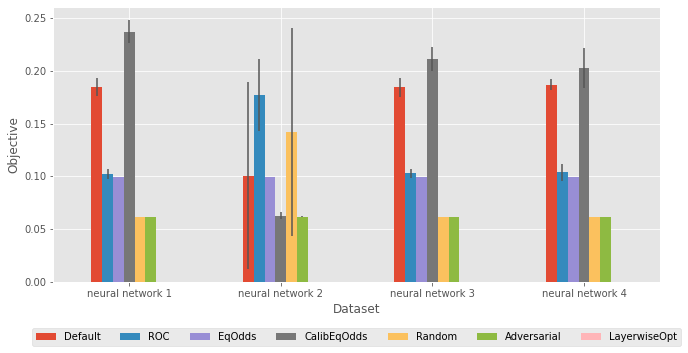

In [197]:
plotdf = pd.DataFrame(data).stack(1).unstack(0).describe().loc[['count', 'mean', 'std']].T.unstack(-1).loc[:,(slice(None, None),'objective')].droplevel(1,1).unstack(1)
plotdf.index = ['neural network 1', 'neural network 2', 'neural network 3', 'neural network 4']

# titlename = {'spd': 'Statistical Parity Difference', 'eod': 'Equal Opportunity Difference', 'aod': 'Average Odds Difference'}
column_order = ['default', 'ROC', 'EqOdds', 'CalibEqOdds', 'Random', 'adversarial', 'layerwiseOpt']
col_rename = {'default': 'Default', 'adversarial': 'Adversarial', 'layerwiseOpt': 'LayerwiseOpt'}

plotmean = plotdf['mean'].reindex(columns=column_order).rename(columns=col_rename)
plotstd = plotdf['std'].reindex(columns=column_order).rename(columns=col_rename)
plotmean.plot(kind='bar', yerr=plotstd, figsize=(10,5), rot=0)
plt.ylabel('Objective')
plt.xlabel('Dataset')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.tight_layout()
# plt.savefig(f'images/{metric}_results.pdf')
plt.savefig(f'images/multinet_results.png')
plt.savefig(f'images/multinet_results.pdf')